In [1]:
import warnings
warnings.filterwarnings('ignore')

import torch
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
import torchvision

In [2]:
def nested_children(m: torch.nn.Module,deeper=False)->dict:
    """Get All Childrens: https://stackoverflow.com/questions/54846905/pytorch-get-all-layers-of-model"""
    children = dict(m.named_children())
    output = {}
    if children == {}:
        # if module has no children; m is last child! :O
        return m
    else:
        # look for children from children... to the last child!
        if deeper==False:
            for name, child in children.items():
                output[name] = child
        else:
            for name, child in children.items():
                output[name] = nested_children(child)
    return output

In [3]:
def show_filers(wis:dict,block:str)->None:
    if hasattr(wis.get('conv1'),'device'):
        if wis.get('conv1').device.type=='cuda': 
            block_weights = wis.get(block).squeeze().permute(1,2,0).detach().cpu()
    else:
        block_weights = wis.get(block).squeeze().transpose(1,2,0)
    list_filters = np.random.randint(low=0,high=block_weights.shape[2],size=16)
    plt.figure(figsize=(8, 6),tight_layout=True)
    plt.suptitle(block,fontsize=16)
    plt.axis('off')
    for i, filter in enumerate(list_filters):
        if i == 16: # we will visualize only 8x8 blocks from each layer
            break
        ax = plt.subplot(4, 4, i + 1)
        ax.set_title('kernel with fiter: {}'.format(filter))
        plt.imshow(block_weights[:,:,filter], cmap='gray')
        plt.axis("off")
        
    plt.show()

In [4]:
device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resize  = torchvision.transforms.Resize((224,224),antialias=False)
img     = torchvision.io.read_image('./assets/streetdogs.jpg')
img     = img.clone().detach().type(dtype=torch.float32).to(device=device,non_blocking=True).unsqueeze(0)  # Make as BATCH

In [5]:
classes = torchvision.models.resnet._IMAGENET_CATEGORIES
model   = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V2).to(device=device).eval()
# summary(model,(3,224,224),device='cuda')

In [6]:
wis = {}
kernels = nested_children(model,deeper=False)
for idx,(name,params) in enumerate(kernels.items()):
    if idx == 0: conv_output = params(img)
    elif name=='fc':
        conv_output = conv_output.view(-1,2048)
        conv_output = params(conv_output)
    else: conv_output = params(conv_output)  
    wis[name]=conv_output

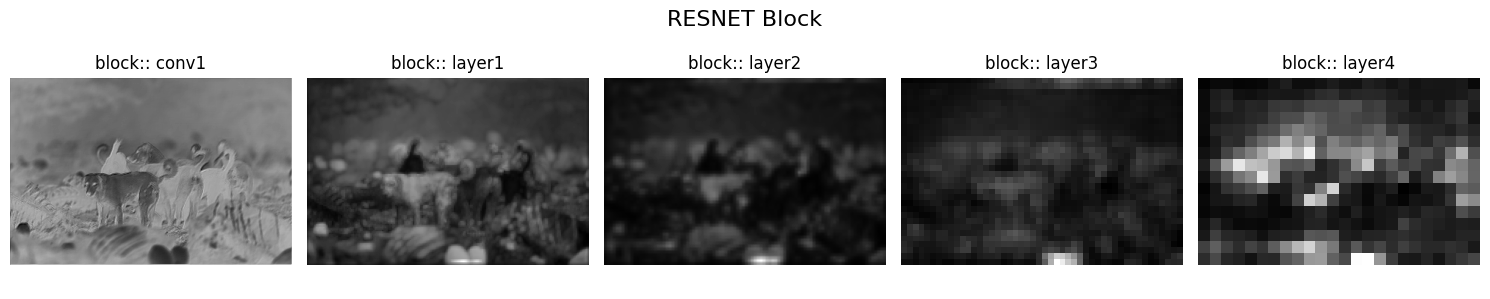

In [7]:
plt.figure(figsize=(15, 3),tight_layout=True)
plt.suptitle('RESNET Block',fontsize=16)
plt.axis('off')
for i,n in enumerate(['conv1','layer1','layer2','layer3','layer4']):
    ax = plt.subplot(1, 5, i + 1)
    ax.set_title('block:: {}'.format(n))
    plt.imshow(wis[n].sum(axis=1).permute(1,2,0).cpu().detach(), cmap='gray')
    plt.axis("off")
    
plt.show()

In [10]:
conv_weights = {}
def pass_through_modules(input_tensor, module, prefix=''):
    for name, child_module in module.named_children():
        if isinstance(child_module, torch.nn.Conv2d):
            output_tensor = child_module(input_tensor.to(device))
            conv_weights[prefix + '.' + name] = output_tensor.detach().cpu().numpy()
            input_tensor = output_tensor
        if name=='downsample':
            # input_tensor = pass_through_modules(input_tensor, child_module, prefix + '.' + name)
            pass
            # return child_module
        elif isinstance(child_module, torch.nn.Sequential) or isinstance(child_module,torchvision.models.resnet.Bottleneck):
            # print(type(child_module))
            input_tensor = pass_through_modules(input_tensor, child_module, prefix + '.' + name)
    return input_tensor
pass_through_modules(img, model,'resnet50');

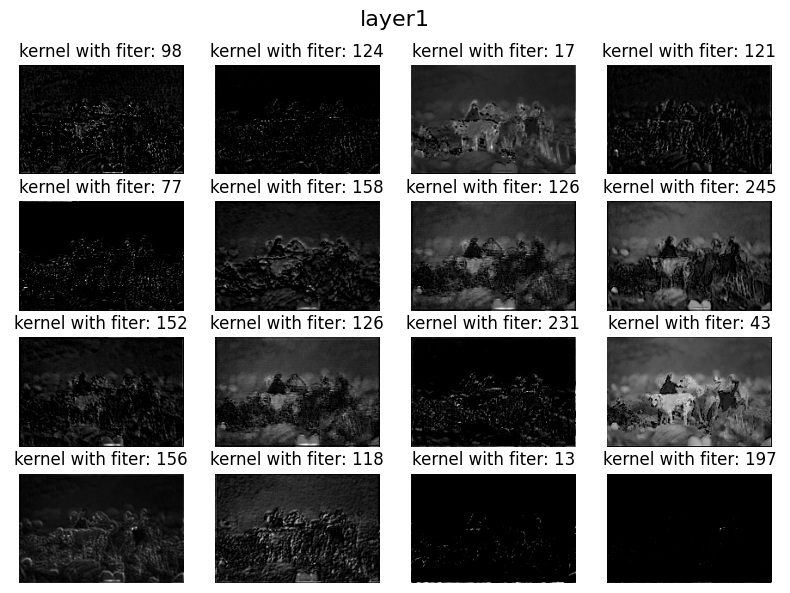

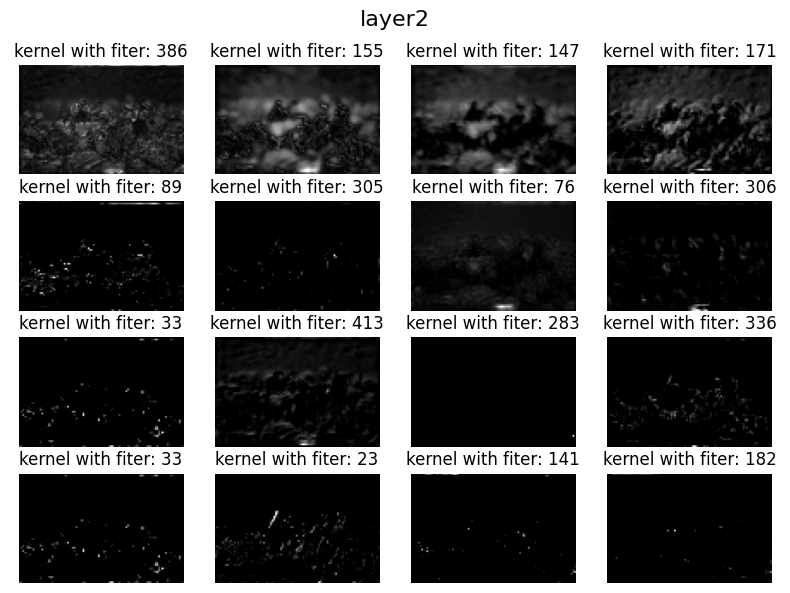

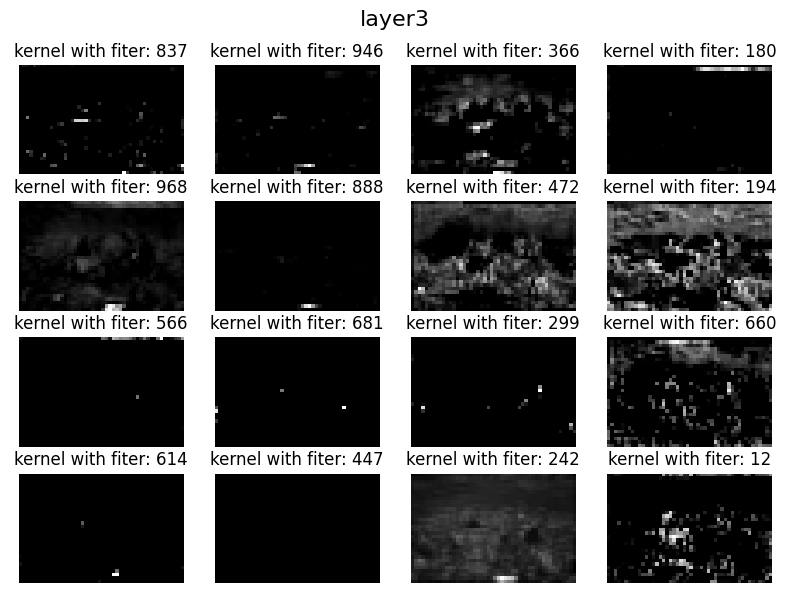

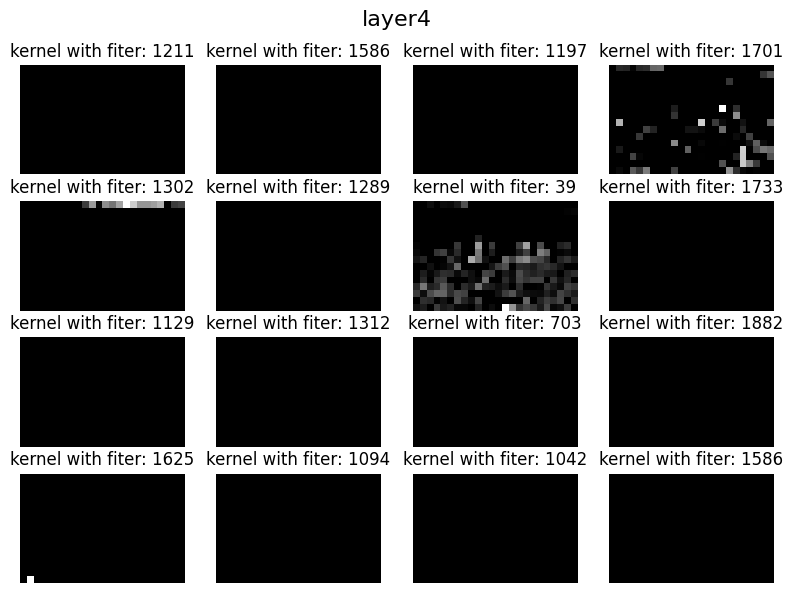

In [11]:
show_filers(wis,'layer1');
show_filers(wis,'layer2');
show_filers(wis,'layer3');
show_filers(wis,'layer4');

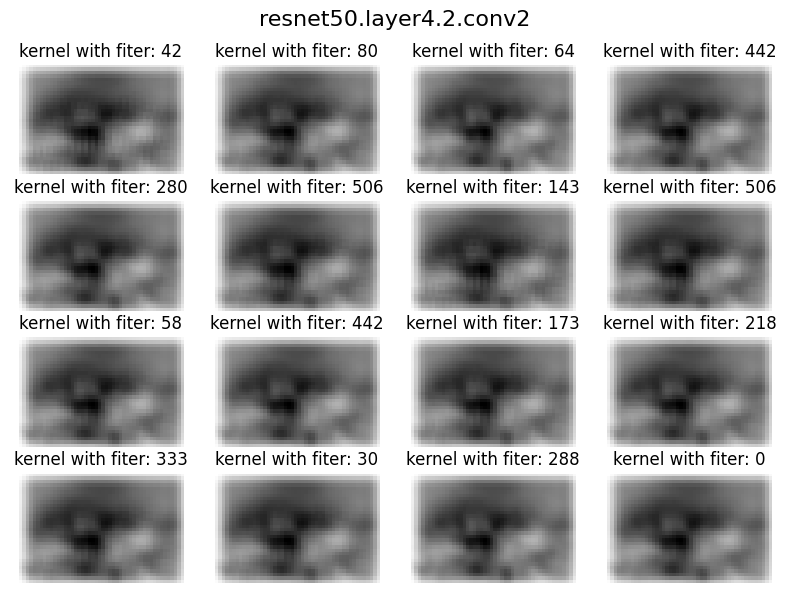

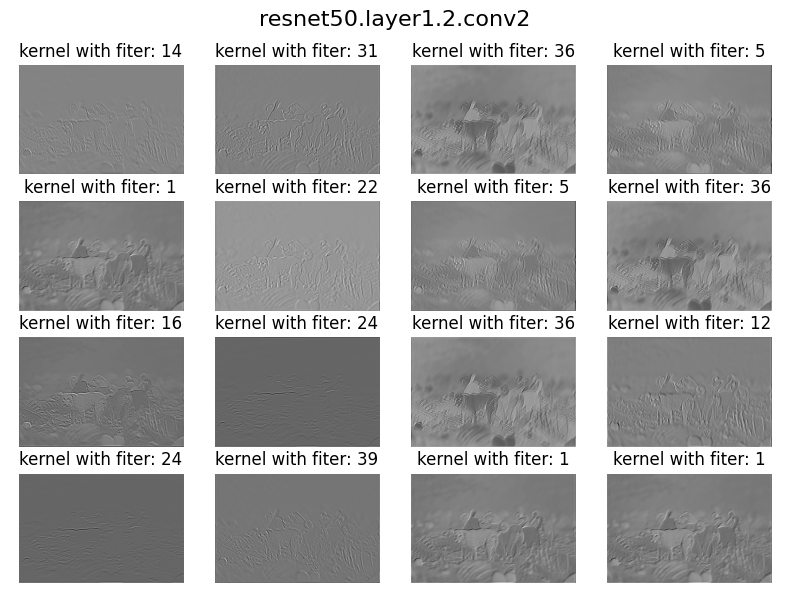

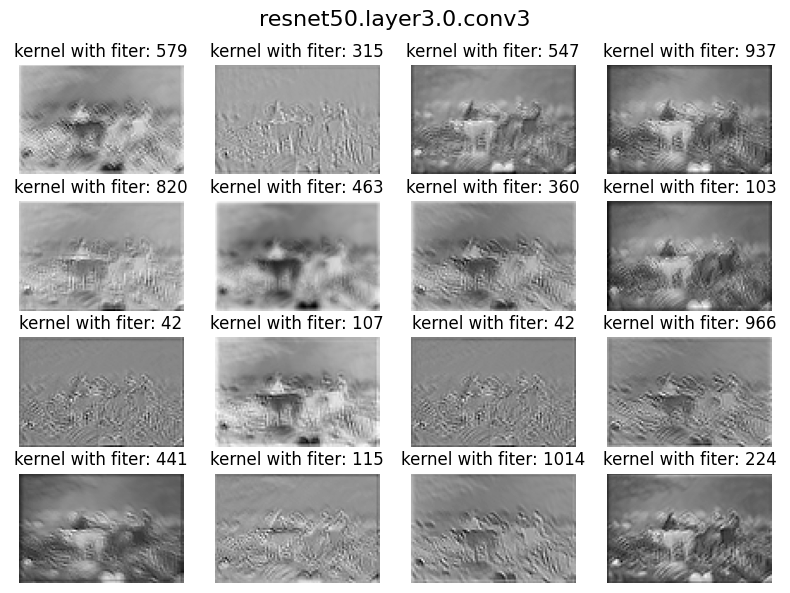

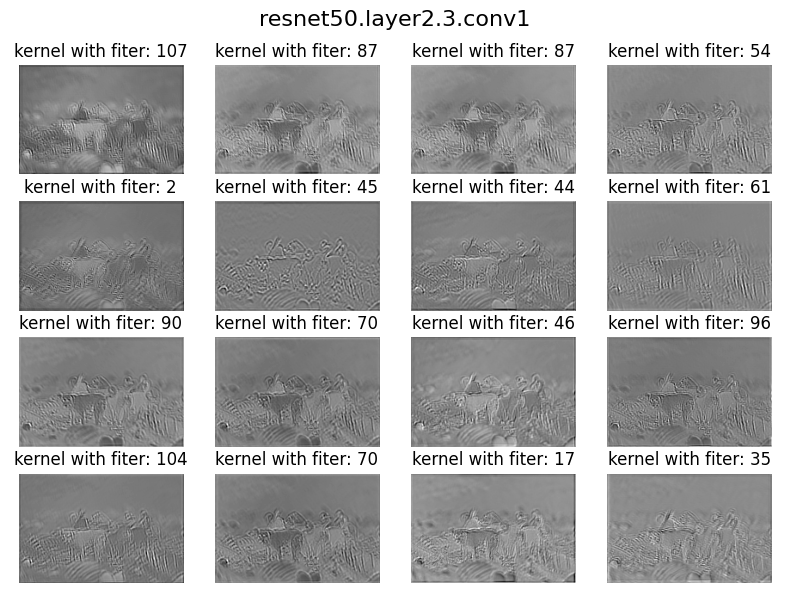

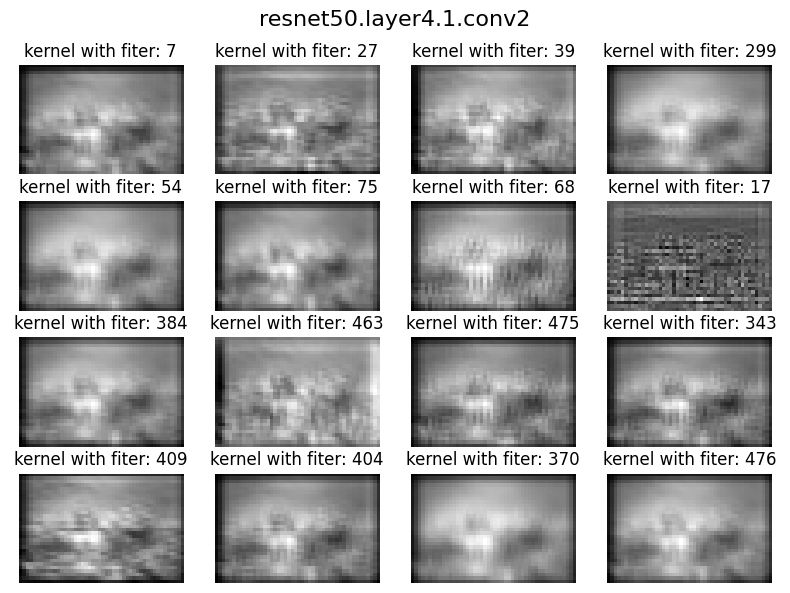

In [12]:
for key in np.random.default_rng().choice(list(conv_weights.keys()), 5):
    show_filers(conv_weights,key);